In [915]:
import pandas as pd
import pyodbc
from catboost import CatBoostRegressor
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error   
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [916]:
server = '10.0.1.40' 
database = 'Ntier_EPIC' 
username = 'Sisenseuser' 
password = '!w@ntd@t@#123'  
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [917]:
query = """Select distinct t1.Service_ID,t1.Patient_Number,t5.patient_age,t1.Actual_Dr_Name,
            t1.Place_of_Service_Abbr,t1.Proc_Category_Abbr,t1.Type_of_Service_Abbr,t5.patient_zip_code,t5.patient_sex,
            t1.Original_Carrier_Name, t5.Patient_City, t5.Patient_State,t2.CoPayment,t2.CoInsurance,t1.Primary_Diagnosis_Code,t1.Procedure_Code,
            t1.Service_Units,convert(Date, t1.Service_Date_From) as Service_Date_From, t1.Claim_Number,
            convert(Date, t1.Original_Billing_Date) as Original_Billing_Date,Convert(Date, t2.Date_Paid) as Date_Paid,
            t1.Service_Fee,t2.Amount, t2.Allowed, t2.Deductible, t2.Transaction_Type, t4.Abbreviation,t4.Description, 
            t4.Self_Pay_TranCode
            from PM.vwGenSvcInfo as T1
            left join PM.[vwGenSvcPmtInfo] T2 ON T1.Service_Id=T2.Service_Id 
            left join PM.Reimbursement_Detail T3 on T1.Service_Id=T3.Service_Id
            left join [dbo].[vUAI_Transaction_Codes] T4 ON T2.Transaction_Code_Abbr=T4.Abbreviation
            left join [EMR].[HPSITE].[DEMOGRAPHICS_VIEW] as d on t1.Patient_Number = d.DEM_EXTERNALID
            left join PM.vwGenPatInfo as T5 ON T1.Patient_Number=T5.Patient_Number
            where (T4.Self_Pay_TranCode=0)
            and (T4.Description not like '%Self%' And T4.Description not like '%Adj%') And (T2.Transaction_Type !='A') and 
            (T2.Transaction_Type !='T') and (T2.Transaction_Type !='B') and (T1.Service_Fee >0)  and (t2.Amount >= 0) and
            ((t1.Primary_Diagnosis_Code between 'E08' and 'E13') OR (t1.Primary_Diagnosis_Code='R73.03'))
            and t2.Date_Paid >= DATEADD(day, -455, GETDATE())
           AND t1.Service_Date_From >= DATEADD(day, -365, DATEADD(day, -90, GETDATE()))"""

df = pd.read_sql(query,cnxn)

In [918]:
df.shape

(105527, 29)

In [919]:
data = df.copy()
data.head() 

,Service_ID,Patient_Number,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,...,Original_Billing_Date,Date_Paid,Service_Fee,Amount,Allowed,Deductible,Transaction_Type,Abbreviation,Description,Self_Pay_TranCode
0,3632971,060933,60,Esther Selik NP,EP Fer,OTHER,OTHER,48224,F,Hap,...,2022-06-11,2022-06-21,31.2,0.00,NaN,NaN,P,COMPMT,Commercial Ins. Payment,False
1,3651482,213200,58,Kristin Iannotti PA-C,EP Fer,LAB CHEM,LAB,48220,F,Medicare Mr,...,2022-06-21,2022-07-05,18.0,0.00,NaN,NaN,P,MRPMT,Medicare Payment,False
2,5159299,731670,72,Shannon Webster PA-C,EPS10Mil,LAB CHEM,LAB,48075,F,Medicare Mr,...,2023-02-28,2023-03-29,22.0,0.00,NaN,NaN,P,MDPMT,Medicaid Payment,False
3,4999178,859160,57,Stacey Couch FNP,EP Fer,LAB CHEM,LAB,48227,F,Allied Benefit Systems Inc,...,2023-01-31,2023-03-07,18.0,6.25,6.25,NaN,P,COMPMT,Commercial Ins. Payment,False
4,3595612,330360,73,Deena Chabaan PA-C,EP Fer,HCPCS_G,OTHER,48030,F,Priority Health Medicare,...,2022-06-03,2022-06-09,295.0,0.00,NaN,NaN,P,MRPMT,Medicare Payment,False


In [921]:
data=data.drop_duplicates()

In [922]:
data.shape

(105527, 29)

In [923]:
data.isna().sum()

Service_ID                     0
Patient_Number                 0
patient_age                    0
Actual_Dr_Name                 0
Place_of_Service_Abbr          0
Proc_Category_Abbr             0
Type_of_Service_Abbr           0
patient_zip_code               0
patient_sex                    0
Original_Carrier_Name        280
Patient_City                   0
Patient_State                  0
CoPayment                 102103
CoInsurance                95615
Primary_Diagnosis_Code         0
Procedure_Code                 0
Service_Units                  0
Service_Date_From              0
Claim_Number                   0
Original_Billing_Date        352
Date_Paid                      0
Service_Fee                    0
Amount                         0
Allowed                    32855
Deductible                100262
Transaction_Type               0
Abbreviation                   0
Description                    0
Self_Pay_TranCode              0
dtype: int64

In [924]:
data = data.dropna(subset = ['Original_Billing_Date','Date_Paid','Original_Carrier_Name'])

In [926]:
data["Original_Billing_Date"] = pd.to_datetime(data["Original_Billing_Date"])      
data["Date_Paid"] = pd.to_datetime(data["Date_Paid"]) 

In [956]:
data["Delay_in_days"] = (pd.to_datetime(data["Date_Paid"]) - pd.to_datetime(data["Original_Billing_Date"])).dt.days
data=data[(data['Delay_in_days'] >= 0) & (data['Delay_in_days'] <= 365)]
data = data.drop(['Delay_in_days'],axis='columns')

In [936]:
data.Amount.describe()

count    103612.000000
mean         16.175854
std          34.252112
min           0.000000
25%           0.000000
50%           2.630000
75%           9.770000
max         354.000000
Name: Amount, dtype: float64

In [712]:
## Score Calculation

In [944]:
#Payment component Calculation

def q3(x):
    """function to return 3rd quartile"""
    return x.quantile(0.75)


In [938]:
data['Amount_per_serv_unit'] = data['Amount']/data['Service_Units']

In [939]:
## finding the q3 for a given cpt by a given payer
cpt_payment_q3 = data.groupby(['Original_Carrier_Name', 'Procedure_Code']).agg({'Amount_per_serv_unit':q3})
cpt_payment_dict = cpt_payment_q3.to_dict('dict')['Amount_per_serv_unit']

## function for calculating the payout_ratio
def get_payout_ratio(row):
    cpt = row['Procedure_Code']
    payor=row['Original_Carrier_Name']
    amt=row['Amount_per_serv_unit']
    med_payout=cpt_payment_dict[payor,str(cpt)]

            
    if med_payout == 0:
        if amt > med_payout:
            payout_ratio = 1
        else:
            payout_ratio = 0
    else:
        if amt > med_payout:
            amt = med_payout
        
        payout_ratio = amt/med_payout
    
    return payout_ratio

In [940]:
# Applying the function to the 'Amount' column
data['payout_ratio'] = data[['Procedure_Code','Original_Carrier_Name','Amount_per_serv_unit']].apply(get_payout_ratio,axis=1)
data['payout_ratio'] = data['payout_ratio'].round(2)

In [941]:
data.payout_ratio.describe()

count    103612.000000
mean          0.489817
std           0.484359
min           0.000000
25%           0.000000
50%           0.500000
75%           1.000000
max           1.000000
Name: payout_ratio, dtype: float64

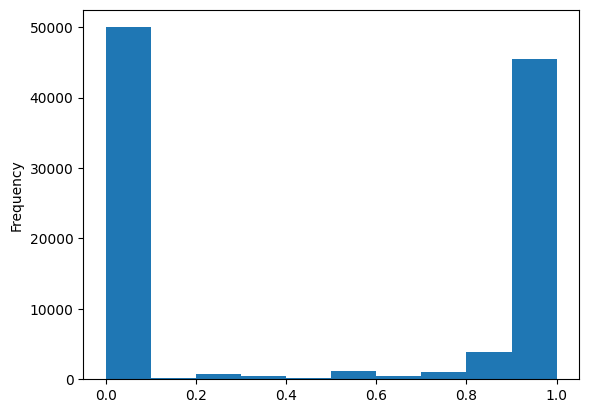

In [942]:
import matplotlib.pyplot as plt
import numpy as np
data.payout_ratio.plot(kind='hist');plt.show()

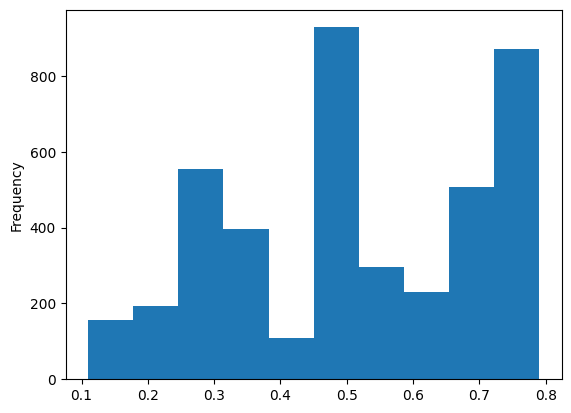

In [943]:
data[(data.payout_ratio<0.8) & (data.payout_ratio>0.1)].payout_ratio.plot(kind='hist');plt.show()

In [948]:
## Delay element
# data["time_decay"] = (1 - (data["Delay_in_days"] / 365))

def get_delay(row):
    
    date_paid = row['Date_Paid']
    billing_date = row['Original_Billing_Date']
    
    diff = (date_paid - billing_date).days
    
    amt = row["Amount"]
    
    if amt == 0:
        return 0
    else:
        return diff
    
data['delay_in_days'] = data[['Original_Billing_Date','Date_Paid','Amount']].apply(get_delay,axis=1)

In [949]:
## finding the median payment for a given cpt by a given payer
cpt_delay_max = data.groupby(['Original_Carrier_Name', 'Procedure_Code'])[['delay_in_days']].max()
cpt_delay_dict = cpt_delay_max.to_dict('dict')['delay_in_days']

## function for calculating the payout_ratio
def get_normed_delay(row):
    cpt = row['Procedure_Code']
    payor = row['Original_Carrier_Name']
    amt = row['Amount']
    delay = row['delay_in_days']
    max_delay = cpt_delay_dict[payor,str(cpt)]
    
    if amt == 0:
        delay_normed = 0
    else:
        try:
            delay_normed = 1 - (delay/max_delay)
        except ZeroDivisionError:
            delay_normed = 0

#     print('delay',delay)
#     print('max delay',max_delay)
#     print('normed',delay_normed)
    
    return delay_normed

In [950]:
data['normalized_delay'] = data[['Procedure_Code','Original_Carrier_Name','Amount','delay_in_days']].apply(get_normed_delay,axis=1)

In [952]:
data.normalized_delay.describe()

count    103612.000000
mean          0.424146
std           0.445419
min           0.000000
25%           0.000000
50%           0.050769
75%           0.936170
max           0.995968
Name: normalized_delay, dtype: float64

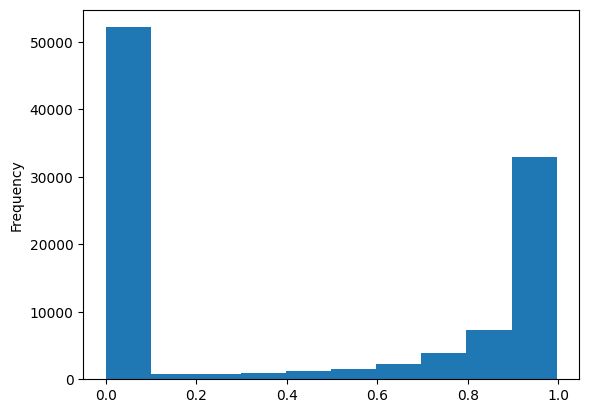

In [953]:
data.normalized_delay.plot(kind='hist');plt.show()

In [958]:
# Final score
payment_wt = 0.75
delay_wt = 0.25

data["Score"] = (payment_wt * data["payout_ratio"]) + (delay_wt * data["normalized_delay"])   
data.head() 

,Service_ID,Patient_Number,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,...,Deductible,Transaction_Type,Abbreviation,Description,Self_Pay_TranCode,Amount_per_serv_unit,payout_ratio,delay_in_days,normalized_delay,Score
0,3632971,060933,60,Esther Selik NP,EP Fer,OTHER,OTHER,48224,F,Hap,...,NaN,P,COMPMT,Commercial Ins. Payment,False,0.00,0.0,0,0.0,0.00
1,3651482,213200,58,Kristin Iannotti PA-C,EP Fer,LAB CHEM,LAB,48220,F,Medicare Mr,...,NaN,P,MRPMT,Medicare Payment,False,0.00,0.0,0,0.0,0.00
2,5159299,731670,72,Shannon Webster PA-C,EPS10Mil,LAB CHEM,LAB,48075,F,Medicare Mr,...,NaN,P,MDPMT,Medicaid Payment,False,0.00,0.0,0,0.0,0.00
3,4999178,859160,57,Stacey Couch FNP,EP Fer,LAB CHEM,LAB,48227,F,Allied Benefit Systems Inc,...,NaN,P,COMPMT,Commercial Ins. Payment,False,6.25,1.0,35,0.0,0.75
4,3595612,330360,73,Deena Chabaan PA-C,EP Fer,HCPCS_G,OTHER,48030,F,Priority Health Medicare,...,NaN,P,MRPMT,Medicare Payment,False,0.00,0.0,0,0.0,0.00


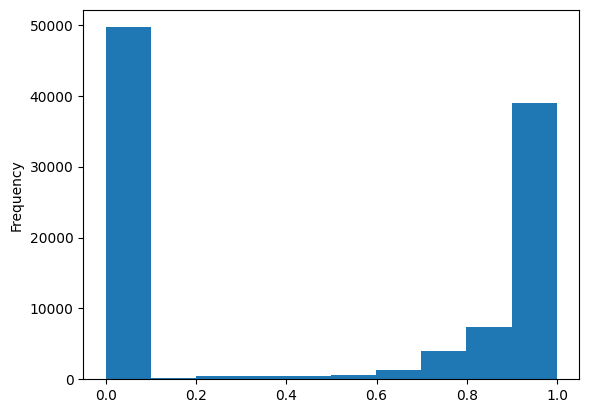

In [959]:
data.Score.plot(kind='hist');plt.show()

In [960]:
co_ins_df = data[~data.CoInsurance.isna()][['Service_ID','Patient_Number','Original_Carrier_Name','CoInsurance','CoPayment','Procedure_Code','Service_Fee','Amount','Allowed','Deductible']]
co_pay_df = data[~data.CoPayment.isna()][['Service_ID','Patient_Number','Original_Carrier_Name','CoInsurance','CoPayment','Procedure_Code','Service_Fee','Amount','Allowed','Deductible']]
co_ins_copay_df = data[~((data.CoInsurance.isna()) | (data.CoPayment.isna()))][['Service_ID','Patient_Number','Original_Carrier_Name','CoInsurance','CoPayment','Procedure_Code','Service_Fee','Amount','Allowed','Deductible']]
deductbl_df = data[~data.Deductible.isna()][['Service_ID','Patient_Number','Original_Carrier_Name','CoInsurance','CoPayment','Procedure_Code','Service_Fee','Amount','Allowed','Deductible']]

all_cpts = data.Procedure_Code.unique().tolist()
copay_cpts = co_pay_df.Procedure_Code.unique().tolist()
coins_cpts = co_ins_df.Procedure_Code.unique().tolist()
copay_coins = set(copay_cpts+coins_cpts)
len(all_cpts),len(copay_coins)

(108, 56)

In [961]:
co_ins_df.shape, co_pay_df.shape

((9709, 10), (3346, 10))

In [966]:
df_by_service_id = data.groupby(["Service_ID"], as_index=False).agg({
    "Patient_Number": "first",
    'patient_age': "max",
    'Actual_Dr_Name': 'first',
    'Place_of_Service_Abbr': 'first',
    'Proc_Category_Abbr': 'first',
    'Type_of_Service_Abbr': 'first',
    'patient_zip_code': "first",
    'patient_sex': "first",
    'Original_Carrier_Name': "first",
    'Patient_City': "first",
    'Patient_State': "first",
    'CoInsurance': "first",
    'CoPayment': "first",
    "Primary_Diagnosis_Code": "first",
    "Procedure_Code": "first",
    'Service_Units': "max",   #sum
    "Service_Fee": "max",
    'Allowed': 'max',
    'Deductible': 'max',
    "Amount":'sum',
    "Score": 'mean'    # sum
}
)


In [967]:
df_by_service_id.shape

(75156, 22)

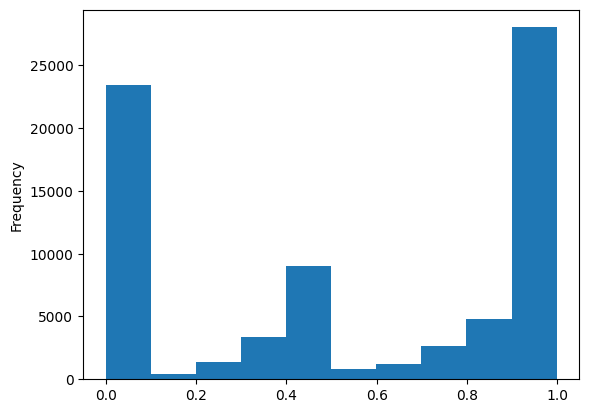

In [963]:
df_by_service_id.Score.plot(kind='hist');plt.show()

In [968]:
df_by_service_id=df_by_service_id[df_by_service_id.Amount <= df_by_service_id.Service_Fee]
df_by_service_id.shape

(75035, 22)

In [969]:
## Missing Value Treatment
df_by_service_id.isna().sum()

Service_ID                    0
Patient_Number                0
patient_age                   0
Actual_Dr_Name                0
Place_of_Service_Abbr         0
Proc_Category_Abbr            0
Type_of_Service_Abbr          0
patient_zip_code              0
patient_sex                   0
Original_Carrier_Name         0
Patient_City                  0
Patient_State                 0
CoInsurance               69515
CoPayment                 72432
Primary_Diagnosis_Code        0
Procedure_Code                0
Service_Units                 0
Service_Fee                   0
Allowed                   22360
Deductible                71144
Amount                        0
Score                         0
dtype: int64

In [970]:
df_by_service_id['CoInsurance'] = df_by_service_id.CoInsurance.fillna(0)
df_by_service_id['CoPayment'] = df_by_service_id.CoPayment.fillna(0)
df_by_service_id['Deductible'] = df_by_service_id.Deductible.fillna(0)

In [971]:
data.Allowed.isna().sum(),df_by_service_id.Allowed.isna().sum()

(32117, 22360)

In [972]:
df_by_service_id['Allowed_per_serv_unit'] = df_by_service_id['Allowed']/df_by_service_id['Service_Units']

In [976]:
## finding the mean 'Allowed' for a given cpt by a given payer
cpt_allowed_mean = df_by_service_id[~df_by_service_id['Allowed_per_serv_unit'].isna()].groupby(['Original_Carrier_Name', 'Procedure_Code'])[['Allowed_per_serv_unit']].mean()
cpt_allowed_dict = cpt_allowed_mean.to_dict('dict')['Allowed_per_serv_unit']

In [977]:
cpt_payer_allowed_dict = {}
for payer_cpt, alwd_value in cpt_allowed_dict.items():
    
    payer_name, cpt_name = payer_cpt
    
    try:
        cpt_payer_allowed_dict[cpt_name][payer_name] = alwd_value
    except KeyError:
        cpt_payer_allowed_dict[cpt_name] = {payer_name:alwd_value}
        

In [978]:
cpt_avg_allowed = {}
for cpt, payer_allwd in cpt_payer_allowed_dict.items():
    avg_allowed = sum(payer_allwd.values())/len(payer_allwd.values())
    cpt_avg_allowed[cpt] = avg_allowed

In [979]:
def get_payer_allowed_value(row):
    
    allowed = row['Allowed']

    if not np.isnan(allowed):
        
        payor_allowed = allowed
    
    else:
        
        cpt = row['Procedure_Code']
        payor = row['Original_Carrier_Name']
        
        
        try:
            payor_allowed = cpt_allowed_dict[payor,str(cpt)]
        except KeyError:
            try:
                payor_allowed = cpt_avg_allowed[cpt]
            except KeyError:
                payor_allowed = None
    return payor_allowed

In [980]:
df_by_service_id['Allowed'] = df_by_service_id.apply(get_payer_allowed_value,axis=1)

In [981]:
df_by_service_id.Allowed.isna().sum()

16

In [982]:
df_by_service_id[df_by_service_id.Allowed.isna()]['Procedure_Code'].unique()

array(['J3301', '76881', '29580', '11055', 'G0447', '99173', '84153',
       '87389', '92568', '90471', '82985', '90837', '99000'], dtype=object)

In [986]:
df_by_service_id.loc[df_by_service_id['Allowed'].isna(), 'Allowed'] = df_by_service_id['Service_Fee']*0.7

In [987]:
df_by_service_id.Allowed.isna().sum()

0

In [988]:
df_by_service_id.Allowed.describe()

count    75035.000000
mean        31.113937
std         45.726357
min          0.010000
25%          4.720000
50%          8.760000
75%         38.080000
max        354.000000
Name: Allowed, dtype: float64

In [989]:
df_by_service_id.columns

Index(['Service_ID', 'Patient_Number', 'patient_age', 'Actual_Dr_Name',
       'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr',
       'patient_zip_code', 'patient_sex', 'Original_Carrier_Name',
       'Patient_City', 'Patient_State', 'CoInsurance', 'CoPayment',
       'Primary_Diagnosis_Code', 'Procedure_Code', 'Service_Units',
       'Service_Fee', 'Allowed', 'Deductible', 'Amount', 'Score',
       'Allowed_per_serv_unit'],
      dtype='object')

In [1048]:
#df_by_service1.to_excel("D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/Ml_model_aggregated_data.xlsx", index = False)
X = df_by_service_id.drop(['Score'],axis='columns')
y = df_by_service_id['Score']

In [1049]:
X.columns

Index(['Service_ID', 'Patient_Number', 'patient_age', 'Actual_Dr_Name',
       'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr',
       'patient_zip_code', 'patient_sex', 'Original_Carrier_Name',
       'Patient_City', 'Patient_State', 'CoInsurance', 'CoPayment',
       'Primary_Diagnosis_Code', 'Procedure_Code', 'Service_Units',
       'Service_Fee', 'Allowed', 'Deductible', 'Amount',
       'Allowed_per_serv_unit'],
      dtype='object')

In [1050]:
cat_cols = ['Actual_Dr_Name', 'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Original_Carrier_Name', 'Patient_City', 'Patient_State', 'Primary_Diagnosis_Code', 'Procedure_Code']
dtype_dict = dict(zip(cat_cols,['category']*len(cat_cols)))


In [1067]:
X = X.astype(dtype_dict)

In [1068]:
X_orig = X_orig.astype(dtype_dict)

In [1061]:
X_orig = df_by_service_id.copy()

In [1069]:
train, test, pt_num_train, pt_num_test = train_test_split(X_orig, X_orig['Patient_Number'], test_size=0.2, random_state=2023)

In [1070]:
y_train = train['Score']
y_test = test['Score']
X_train = train.drop(['Score'],axis=1)
X_test = test.drop(['Score'],axis=1)

In [1071]:
# Drop unneeded columns
cols_to_drop = ['Service_ID', 'Patient_Number','Amount','Allowed_per_serv_unit']
X_train = X_train.drop(cols_to_drop,axis='columns')
X_test = X_test.drop(cols_to_drop,axis='columns')

In [1073]:
X_train.shape, y_train.shape

((60028, 18), (60028,))

In [1074]:
X_train.columns           

Index(['patient_age', 'Actual_Dr_Name', 'Place_of_Service_Abbr',
       'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code',
       'patient_sex', 'Original_Carrier_Name', 'Patient_City', 'Patient_State',
       'CoInsurance', 'CoPayment', 'Primary_Diagnosis_Code', 'Procedure_Code',
       'Service_Units', 'Service_Fee', 'Allowed', 'Deductible'],
      dtype='object')

In [997]:
# y = y*100

In [818]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [819]:
# X_train = X_train[['patient_age','patient_sex','Actual_Dr_Name','Procedure_Code','Original_Carrier_Name']]
# X_test = X_test[['patient_age','patient_sex','Actual_Dr_Name','Procedure_Code','Original_Carrier_Name']]

In [1075]:
# catboost model after removing outliers and attributes
# List of categorical columns
categoricalcolumns = X_train.select_dtypes(include=["category"]).columns.tolist()
print("Names of categorical columns : ", categoricalcolumns)
# Get location of categorical columns
cat_features = [X_train.columns.get_loc(col) for col in categoricalcolumns]
print("Location of categorical columns : ", cat_features)
cat_features = [int(i) for i in cat_features]

Names of categorical columns :  ['Actual_Dr_Name', 'Place_of_Service_Abbr', 'Proc_Category_Abbr', 'Type_of_Service_Abbr', 'patient_zip_code', 'patient_sex', 'Original_Carrier_Name', 'Patient_City', 'Patient_State', 'Primary_Diagnosis_Code', 'Procedure_Code']
Location of categorical columns :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13]


In [1076]:
from catboost import Pool
# Creating pool object for train dataset. we give information of categorical features to parameter cat_features
# Creating pool object for train dataset. we give information of categorical features to parameter cat_features
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                  )
# Creating pool object for test dataset
test_data = Pool(data=X_test,
                 label=y_test,
                 cat_features=cat_features
                 )

# build model
print("model is training...")
print("----------------------")
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=True)
# Fit model
cat_model.fit(train_data)
print("Training completed...")
print("----------------------")

model is training...
----------------------
Learning rate set to 0.078191
0:	learn: 0.4041496	total: 134ms	remaining: 2m 13s
1:	learn: 0.3918818	total: 256ms	remaining: 2m 7s
2:	learn: 0.3779073	total: 362ms	remaining: 2m
3:	learn: 0.3654879	total: 473ms	remaining: 1m 57s
4:	learn: 0.3547984	total: 582ms	remaining: 1m 55s
5:	learn: 0.3448727	total: 689ms	remaining: 1m 54s
6:	learn: 0.3361595	total: 781ms	remaining: 1m 50s
7:	learn: 0.3283326	total: 872ms	remaining: 1m 48s
8:	learn: 0.3218006	total: 993ms	remaining: 1m 49s
9:	learn: 0.3160429	total: 1.11s	remaining: 1m 49s
10:	learn: 0.3109097	total: 1.22s	remaining: 1m 49s
11:	learn: 0.3064639	total: 1.31s	remaining: 1m 48s
12:	learn: 0.3025491	total: 1.44s	remaining: 1m 49s
13:	learn: 0.2991470	total: 1.55s	remaining: 1m 48s
14:	learn: 0.2961560	total: 1.64s	remaining: 1m 47s
15:	learn: 0.2935590	total: 1.78s	remaining: 1m 49s
16:	learn: 0.2912291	total: 1.91s	remaining: 1m 50s
17:	learn: 0.2893183	total: 1.99s	remaining: 1m 48s
18:	l

156:	learn: 0.2498011	total: 19.1s	remaining: 1m 42s
157:	learn: 0.2497684	total: 19.2s	remaining: 1m 42s
158:	learn: 0.2496604	total: 19.3s	remaining: 1m 42s
159:	learn: 0.2495559	total: 19.4s	remaining: 1m 41s
160:	learn: 0.2494584	total: 19.5s	remaining: 1m 41s
161:	learn: 0.2493324	total: 19.6s	remaining: 1m 41s
162:	learn: 0.2492488	total: 19.8s	remaining: 1m 41s
163:	learn: 0.2491285	total: 19.9s	remaining: 1m 41s
164:	learn: 0.2489944	total: 20s	remaining: 1m 41s
165:	learn: 0.2489035	total: 20.1s	remaining: 1m 41s
166:	learn: 0.2488141	total: 20.2s	remaining: 1m 40s
167:	learn: 0.2487047	total: 20.3s	remaining: 1m 40s
168:	learn: 0.2485814	total: 20.4s	remaining: 1m 40s
169:	learn: 0.2484357	total: 20.6s	remaining: 1m 40s
170:	learn: 0.2483879	total: 20.7s	remaining: 1m 40s
171:	learn: 0.2482171	total: 20.8s	remaining: 1m 40s
172:	learn: 0.2480926	total: 20.9s	remaining: 1m 39s
173:	learn: 0.2479981	total: 21s	remaining: 1m 39s
174:	learn: 0.2479191	total: 21.2s	remaining: 1m 3

312:	learn: 0.2394063	total: 37.1s	remaining: 1m 21s
313:	learn: 0.2393353	total: 37.2s	remaining: 1m 21s
314:	learn: 0.2392507	total: 37.4s	remaining: 1m 21s
315:	learn: 0.2391621	total: 37.5s	remaining: 1m 21s
316:	learn: 0.2391447	total: 37.6s	remaining: 1m 20s
317:	learn: 0.2390990	total: 37.7s	remaining: 1m 20s
318:	learn: 0.2389563	total: 37.8s	remaining: 1m 20s
319:	learn: 0.2388284	total: 37.9s	remaining: 1m 20s
320:	learn: 0.2387870	total: 38s	remaining: 1m 20s
321:	learn: 0.2387662	total: 38.2s	remaining: 1m 20s
322:	learn: 0.2387359	total: 38.3s	remaining: 1m 20s
323:	learn: 0.2387001	total: 38.4s	remaining: 1m 20s
324:	learn: 0.2386881	total: 38.5s	remaining: 1m 19s
325:	learn: 0.2386634	total: 38.6s	remaining: 1m 19s
326:	learn: 0.2386624	total: 38.7s	remaining: 1m 19s
327:	learn: 0.2386165	total: 38.8s	remaining: 1m 19s
328:	learn: 0.2386050	total: 38.9s	remaining: 1m 19s
329:	learn: 0.2385843	total: 39.1s	remaining: 1m 19s
330:	learn: 0.2384987	total: 39.2s	remaining: 1m

470:	learn: 0.2333926	total: 55.2s	remaining: 1m 1s
471:	learn: 0.2333404	total: 55.3s	remaining: 1m 1s
472:	learn: 0.2333043	total: 55.4s	remaining: 1m 1s
473:	learn: 0.2332846	total: 55.5s	remaining: 1m 1s
474:	learn: 0.2332441	total: 55.6s	remaining: 1m 1s
475:	learn: 0.2332259	total: 55.8s	remaining: 1m 1s
476:	learn: 0.2332078	total: 55.9s	remaining: 1m 1s
477:	learn: 0.2331443	total: 56.1s	remaining: 1m 1s
478:	learn: 0.2331292	total: 56.2s	remaining: 1m 1s
479:	learn: 0.2331142	total: 56.3s	remaining: 1m
480:	learn: 0.2330984	total: 56.4s	remaining: 1m
481:	learn: 0.2330567	total: 56.5s	remaining: 1m
482:	learn: 0.2330033	total: 56.6s	remaining: 1m
483:	learn: 0.2329968	total: 56.7s	remaining: 1m
484:	learn: 0.2329516	total: 56.9s	remaining: 1m
485:	learn: 0.2329192	total: 57s	remaining: 1m
486:	learn: 0.2328755	total: 57.1s	remaining: 1m
487:	learn: 0.2328631	total: 57.2s	remaining: 1m
488:	learn: 0.2328162	total: 57.3s	remaining: 59.9s
489:	learn: 0.2328064	total: 57.4s	remain

631:	learn: 0.2287920	total: 1m 14s	remaining: 43.1s
632:	learn: 0.2287704	total: 1m 14s	remaining: 43s
633:	learn: 0.2287406	total: 1m 14s	remaining: 42.9s
634:	learn: 0.2287232	total: 1m 14s	remaining: 42.7s
635:	learn: 0.2286774	total: 1m 14s	remaining: 42.6s
636:	learn: 0.2286754	total: 1m 14s	remaining: 42.5s
637:	learn: 0.2286696	total: 1m 14s	remaining: 42.4s
638:	learn: 0.2286574	total: 1m 14s	remaining: 42.3s
639:	learn: 0.2286461	total: 1m 14s	remaining: 42.1s
640:	learn: 0.2286184	total: 1m 15s	remaining: 42s
641:	learn: 0.2286183	total: 1m 15s	remaining: 41.9s
642:	learn: 0.2286032	total: 1m 15s	remaining: 41.8s
643:	learn: 0.2285951	total: 1m 15s	remaining: 41.7s
644:	learn: 0.2285835	total: 1m 15s	remaining: 41.5s
645:	learn: 0.2285647	total: 1m 15s	remaining: 41.4s
646:	learn: 0.2285566	total: 1m 15s	remaining: 41.3s
647:	learn: 0.2285465	total: 1m 15s	remaining: 41.2s
648:	learn: 0.2285277	total: 1m 15s	remaining: 41.1s
649:	learn: 0.2285247	total: 1m 16s	remaining: 41s

788:	learn: 0.2253617	total: 1m 32s	remaining: 24.8s
789:	learn: 0.2253575	total: 1m 33s	remaining: 24.7s
790:	learn: 0.2253389	total: 1m 33s	remaining: 24.6s
791:	learn: 0.2253064	total: 1m 33s	remaining: 24.5s
792:	learn: 0.2253030	total: 1m 33s	remaining: 24.4s
793:	learn: 0.2252887	total: 1m 33s	remaining: 24.3s
794:	learn: 0.2252706	total: 1m 33s	remaining: 24.2s
795:	learn: 0.2252633	total: 1m 33s	remaining: 24s
796:	learn: 0.2252318	total: 1m 33s	remaining: 23.9s
797:	learn: 0.2252102	total: 1m 34s	remaining: 23.8s
798:	learn: 0.2251795	total: 1m 34s	remaining: 23.7s
799:	learn: 0.2251534	total: 1m 34s	remaining: 23.6s
800:	learn: 0.2251457	total: 1m 34s	remaining: 23.5s
801:	learn: 0.2251060	total: 1m 34s	remaining: 23.3s
802:	learn: 0.2250949	total: 1m 34s	remaining: 23.2s
803:	learn: 0.2250484	total: 1m 34s	remaining: 23.1s
804:	learn: 0.2250093	total: 1m 34s	remaining: 23s
805:	learn: 0.2249961	total: 1m 35s	remaining: 22.9s
806:	learn: 0.2249855	total: 1m 35s	remaining: 22.

944:	learn: 0.2224152	total: 1m 51s	remaining: 6.49s
945:	learn: 0.2223986	total: 1m 51s	remaining: 6.37s
946:	learn: 0.2223892	total: 1m 51s	remaining: 6.25s
947:	learn: 0.2223788	total: 1m 51s	remaining: 6.13s
948:	learn: 0.2223732	total: 1m 51s	remaining: 6.01s
949:	learn: 0.2223718	total: 1m 52s	remaining: 5.9s
950:	learn: 0.2223586	total: 1m 52s	remaining: 5.78s
951:	learn: 0.2223481	total: 1m 52s	remaining: 5.66s
952:	learn: 0.2223439	total: 1m 52s	remaining: 5.54s
953:	learn: 0.2223426	total: 1m 52s	remaining: 5.42s
954:	learn: 0.2223345	total: 1m 52s	remaining: 5.31s
955:	learn: 0.2223278	total: 1m 52s	remaining: 5.19s
956:	learn: 0.2223224	total: 1m 52s	remaining: 5.07s
957:	learn: 0.2223097	total: 1m 53s	remaining: 4.95s
958:	learn: 0.2223016	total: 1m 53s	remaining: 4.83s
959:	learn: 0.2222726	total: 1m 53s	remaining: 4.72s
960:	learn: 0.2222695	total: 1m 53s	remaining: 4.6s
961:	learn: 0.2222585	total: 1m 53s	remaining: 4.48s
962:	learn: 0.2221933	total: 1m 53s	remaining: 4

In [1077]:
cat_model.score(X_test,y_test)

0.7185316376599815

In [1078]:
# Prediction on train and test
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)
print("----------------------")
print("Results and performance on the training and testing data")
print("----------------------")
print("Train set performance")
rmse = mean_squared_error(y_train, y_train_pred)**0.5
print("Root Mean squared error {:.3f}".format(rmse))
print("----------------------")
print("Test set performance")
rmse = mean_squared_error(y_test, y_test_pred)**0.5
print("Root Mean squared error {:.3f}".format(rmse))
# pickle.dump(cat_model, open(r"D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/catboost_model1.pkl", 'wb'))

----------------------
Results and performance on the training and testing data
----------------------
Train set performance
Root Mean squared error 0.193
----------------------
Test set performance
Root Mean squared error 0.221


In [1079]:
print("Training performance")
mean_abs_error = mean_absolute_error(y_train, y_train_pred)
print("Mean abs error {:.2f}".format(mean_abs_error))
print("----------------------")
print("Testing performance")
mean_abs_error = mean_absolute_error(y_test, y_test_pred)
print("Mean abs error {:.2f}".format(mean_abs_error))

Training performance
Mean abs error 0.13
----------------------
Testing performance
Mean abs error 0.15


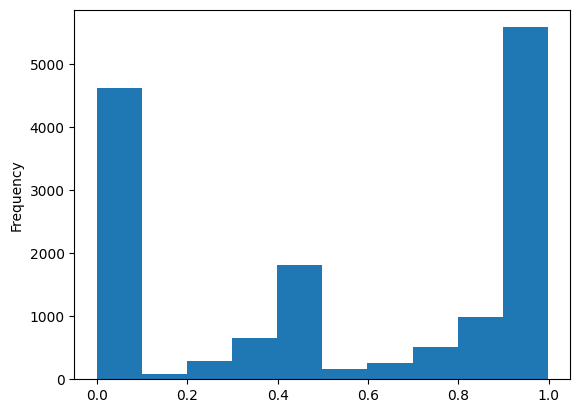

In [1080]:
y_test.plot(kind='hist');plt.show()

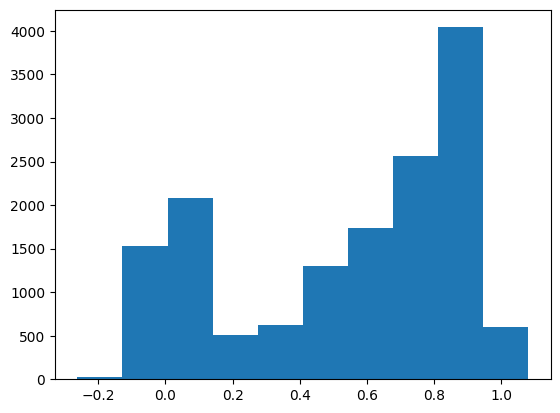

In [1081]:
plt.hist(y_test_pred)
plt.show()

In [1082]:
pred_df = pd.DataFrame({'actual':y_test,'pred':y_test_pred,'abs_error':abs(y_test - y_test_pred)})

In [1083]:
pred_df.head()

,actual,pred,abs_error
30521,0.497556,0.784402,0.286846
31473,0.000000,0.253019,0.253019
63521,0.000000,-0.001049,0.001049
22004,0.247222,0.536282,0.289059
23211,0.328591,0.393507,0.064916


In [1084]:
pred_df.abs_error.describe()

count    15007.000000
mean         0.153041
std          0.159607
min          0.000006
25%          0.038021
50%          0.100794
75%          0.210798
max          0.990445
Name: abs_error, dtype: float64

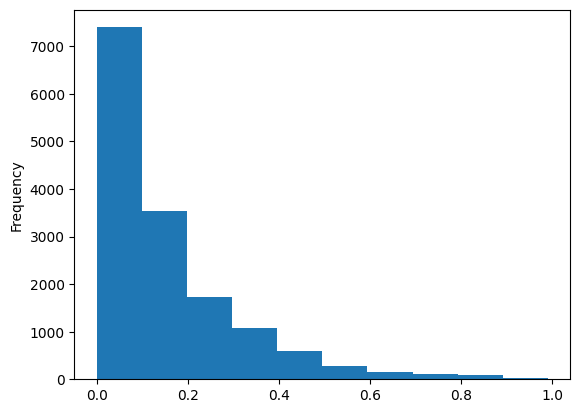

In [1085]:
pred_df.abs_error.plot(kind='hist');plt.show()

In [1090]:
(pred_df.abs_error<0.3).sum()/pred_df.shape[0]

0.847271273405744

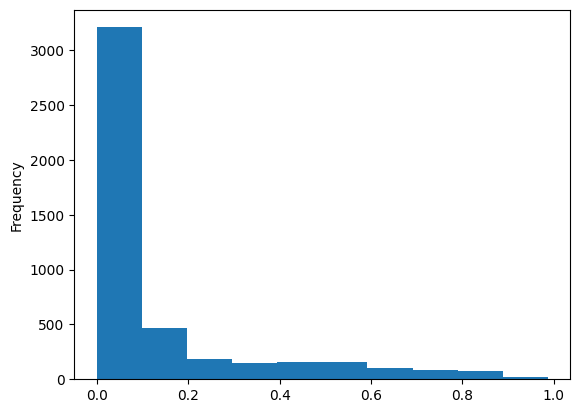

In [1091]:
pred_df[pred_df.actual<0.10].abs_error.plot(kind='hist');plt.show()

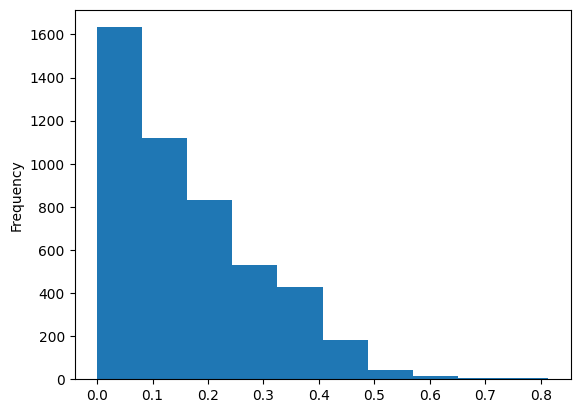

In [1092]:
pred_df[(pred_df.actual>0.10) & (pred_df.actual<0.90)].abs_error.plot(kind='hist');plt.show()

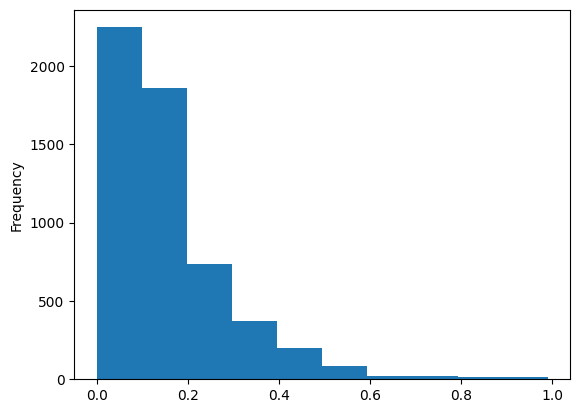

In [1093]:
pred_df[pred_df.actual>0.90].abs_error.plot(kind='hist');plt.show()

In [1094]:
## Linear Regression
from sklearn.linear_model import LinearRegression

In [1095]:
reg = LinearRegression()

In [1096]:
X_train_dummified = pd.get_dummies(X_train)

X_test_dummified = pd.get_dummies(X_test)

In [1097]:
reg.fit(X_train_dummified, y_train)

LinearRegression()

In [1098]:
reg.score(X_test_dummified,y_test)

0.3704457987396501

In [1100]:
train_preds = reg.predict(X_train_dummified)

lr_preds = reg.predict(X_test_dummified)

print("Training performance")
mean_sq_error = mean_absolute_error(y_train, train_preds)
print("Mean abs error {:.2f}".format(mean_sq_error))
print("----------------------")
print("Testing performance")
mean_sq_error = mean_absolute_error(y_test, lr_preds)
print("Mean abs error {:.2f}".format(mean_sq_error))
# pickle.dump(cat_model, open(r"D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/catboost_model1.pkl", 'wb'))

Training performance
Mean abs error 0.27
----------------------
Testing performance
Mean abs error 0.27


In [1101]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

In [1102]:
rf = RandomForestRegressor(verbose=1,n_jobs=4)
rf.fit(X_train_dummified,y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.3min finished


RandomForestRegressor(n_jobs=4, verbose=1)

In [1103]:
rf.score(X_test_dummified,y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


0.7332139195470115

In [1104]:
forest_importances = pd.Series(rf.feature_importances_, index=X_test_dummified.columns)

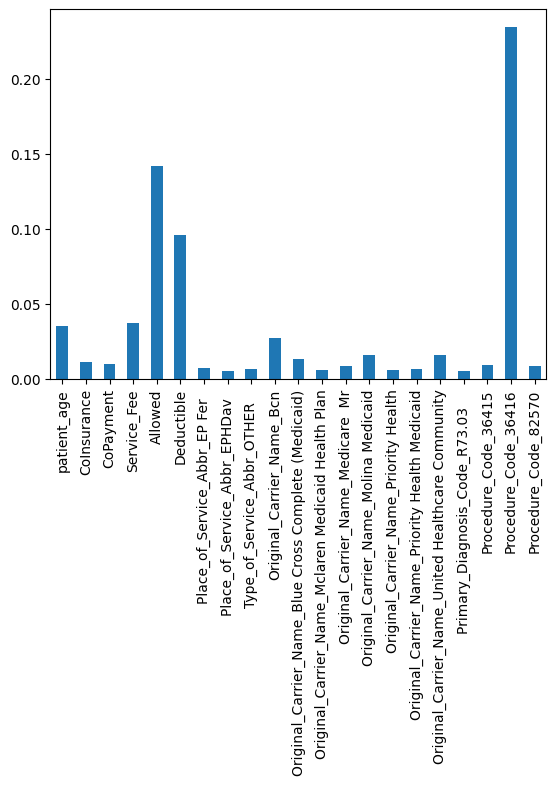

In [1105]:
top_feat = forest_importances[forest_importances>0.005]
top_feat.plot.bar();plt.show()

In [1106]:
rf_train_preds = rf.predict(X_train_dummified)
rf_preds = rf.predict(X_test_dummified)

print("Train set performance")
mean_abs_error = mean_absolute_error(y_train, rf_train_preds)
print("Mean absolute error {:.2f}".format(mean_abs_error))
print("----------------------")
print("Test set performance")
mean_abs_error = mean_absolute_error(y_test, rf_preds)
print("Mean absolute error {:.2f}".format(mean_abs_error))
# pickle.dump(cat_model, open(r"D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/catboost_model1.pkl", 'wb'))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Train set performance
Mean absolute error 0.05
----------------------
Test set performance
Mean absolute error 0.13


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [1107]:
## XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor(n_jobs=4)

In [1108]:
xgb.fit(X_train_dummified,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=4, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

In [1109]:
xgb.score(X_train_dummified,y_train),xgb.score(X_test_dummified,y_test)

(0.7076242950343407, 0.6683694922339172)

In [1110]:
xgb_train_preds = xgb.predict(X_train_dummified)
xgb_preds = xgb.predict(X_test_dummified)

print("Train set performance")
mean_abs_error = mean_absolute_error(y_train, xgb_train_preds)
print("Mean absolute error {:.2f}".format(mean_abs_error))
print("----------------------")
print("Test set performance")
mean_abs_error = mean_absolute_error(y_test, xgb_preds)
print("Mean absolute error {:.2f}".format(mean_abs_error))
# pickle.dump(cat_model, open(r"D:/OneDrive - Quadratic Insights Pvt Ltd/Desktop/Prediction_Engine/catboost_model1.pkl", 'wb'))

Train set performance
Mean absolute error 0.17
----------------------
Test set performance
Mean absolute error 0.18


### Model using 'allowed' for target var calculation 

In [1357]:
data_ald = df.copy()
data_ald.head() 

,Service_ID,Patient_Number,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,...,Original_Billing_Date,Date_Paid,Service_Fee,Amount,Allowed,Deductible,Transaction_Type,Abbreviation,Description,Self_Pay_TranCode
0,3632971,060933,60,Esther Selik NP,EP Fer,OTHER,OTHER,48224,F,Hap,...,2022-06-11,2022-06-21,31.2,0.00,NaN,NaN,P,COMPMT,Commercial Ins. Payment,False
1,3651482,213200,58,Kristin Iannotti PA-C,EP Fer,LAB CHEM,LAB,48220,F,Medicare Mr,...,2022-06-21,2022-07-05,18.0,0.00,NaN,NaN,P,MRPMT,Medicare Payment,False
2,5159299,731670,72,Shannon Webster PA-C,EPS10Mil,LAB CHEM,LAB,48075,F,Medicare Mr,...,2023-02-28,2023-03-29,22.0,0.00,NaN,NaN,P,MDPMT,Medicaid Payment,False
3,4999178,859160,57,Stacey Couch FNP,EP Fer,LAB CHEM,LAB,48227,F,Allied Benefit Systems Inc,...,2023-01-31,2023-03-07,18.0,6.25,6.25,NaN,P,COMPMT,Commercial Ins. Payment,False
4,3595612,330360,73,Deena Chabaan PA-C,EP Fer,HCPCS_G,OTHER,48030,F,Priority Health Medicare,...,2022-06-03,2022-06-09,295.0,0.00,NaN,NaN,P,MRPMT,Medicare Payment,False


In [1358]:
data_ald = data_ald.drop_duplicates()
data_ald = data_ald.dropna(subset = ['Original_Billing_Date','Date_Paid','Original_Carrier_Name'])

In [1359]:
data_ald["Original_Billing_Date"] = pd.to_datetime(data_ald["Original_Billing_Date"])      
data_ald["Date_Paid"] = pd.to_datetime(data_ald["Date_Paid"]) 

In [1360]:
data_ald["Delay_in_days"] = (pd.to_datetime(data_ald["Date_Paid"]) - pd.to_datetime(data_ald["Original_Billing_Date"])).dt.days
data_ald=data_ald[(data_ald['Delay_in_days'] >= 0) & (data_ald['Delay_in_days'] <= 365)]
data_ald = data_ald.drop(['Delay_in_days'],axis='columns')

In [1383]:
data_ald_by_service_id = data_ald.groupby(["Service_ID"], as_index=False).agg({
    "Patient_Number": "first",
    'patient_age': "max",
    'Actual_Dr_Name': 'first',
    'Place_of_Service_Abbr': 'first',
    'Proc_Category_Abbr': 'first',
    'Type_of_Service_Abbr': 'first',
    'patient_zip_code': "first",
    'patient_sex': "first",
    'Original_Carrier_Name': "first",
    'Patient_City': "first",
    'Patient_State': "first",
    'CoInsurance': "max",
    'CoPayment': "max",
    "Primary_Diagnosis_Code": "first",
    "Procedure_Code": "first",
    'Service_Units': "max",   #sum
    "Service_Fee": "max",
    'Allowed': 'max',
    'Deductible': 'max',
    "Amount":'sum',
}
)


## Score Calculation

In [1385]:
#Payment component Calculation
data_ald_by_service_id['Amount_per_serv_unit'] = data_ald_by_service_id['Amount']/data_ald_by_service_id['Service_Units']

In [1390]:
data_ald.shape[0],data_ald.Allowed.isna().sum(),data_ald_by_service_id.Allowed.isna().sum()

(103612, 32117, 22370)

In [1387]:
data_ald_by_service_id['Allowed_per_serv_unit'] = data_ald_by_service_id['Allowed']/data_ald_by_service_id['Service_Units']

In [1388]:
data_ald_by_service_id.Allowed_per_serv_unit.isna().sum()

22370

In [1365]:
# Filling missing values in Allowed column

In [1391]:
## finding the mean 'Allowed' for a given cpt by a given payer
cpt_allowed_mean = data_ald_by_service_id[~data_ald_by_service_id['Allowed_per_serv_unit'].isna()].groupby(['Original_Carrier_Name', 'Procedure_Code'])[['Allowed_per_serv_unit']].mean()
cpt_allowed_dict = cpt_allowed_mean.to_dict('dict')['Allowed_per_serv_unit']

In [1392]:
cpt_payer_allowed_dict = {}
for payer_cpt, alwd_value in cpt_allowed_dict.items():
    
    payer_name, cpt_name = payer_cpt
    
    try:
        cpt_payer_allowed_dict[cpt_name][payer_name] = alwd_value
    except KeyError:
        cpt_payer_allowed_dict[cpt_name] = {payer_name:alwd_value}
        

In [1393]:
# cpt_allowed_dict = {cpt:list(d.values()) for cpt,d in cpt_payer_allowed_dict.items()}

In [1394]:
cpt_avg_allowed = {}
for cpt, payer_allwd in cpt_payer_allowed_dict.items():
    avg_allowed = sum(payer_allwd.values())/len(payer_allwd.values())
    cpt_avg_allowed[cpt] = avg_allowed

In [1395]:
def get_payer_allowed_value(row):
    
    allowed = row['Allowed_per_serv_unit']

    if not np.isnan(allowed):
        
        payor_allowed = allowed
    
    else:
        
        cpt = row['Procedure_Code']
        payor = row['Original_Carrier_Name']
        
        
        try:
            payor_allowed = cpt_allowed_dict[payor,str(cpt)]
        except KeyError:
            try:
                payor_allowed = cpt_avg_allowed[cpt]
            except KeyError:
                payor_allowed = None
    return payor_allowed

In [1407]:
data_ald_by_service_id['Allowed_per_serv_unit'] = data_ald_by_service_id.apply(get_payer_allowed_value,axis=1)

In [1408]:
data_ald_by_service_id.Allowed_per_serv_unit.isna().sum()

16

In [1409]:
data_ald_by_service_id['Service_Fee_per_serv_unit'] = data_ald_by_service_id['Service_Fee']/data_ald_by_service_id['Service_Units']

In [1410]:
data_ald_by_service_id['allowed_ratio'] = data_ald_by_service_id['Allowed_per_serv_unit']/data_ald_by_service_id['Service_Fee_per_serv_unit']

In [1411]:
data_ald_by_service_id['allowed_ratio'].describe()

count    75140.000000
mean         0.393713
std          0.186941
min          0.000028
25%          0.264167
50%          0.389167
75%          0.502188
max          1.360000
Name: allowed_ratio, dtype: float64

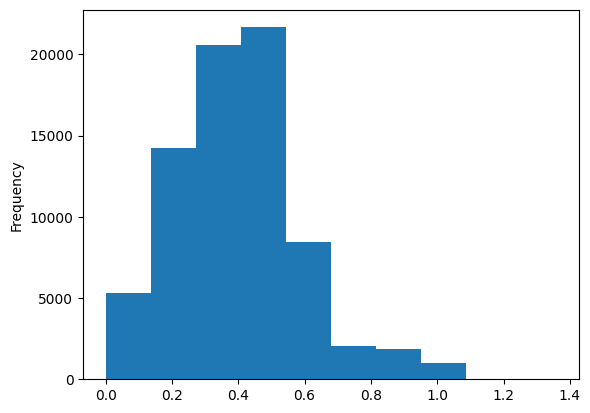

In [1412]:
data_ald_by_service_id['allowed_ratio'].plot(kind='hist');plt.show()

In [1413]:
allowed_ratio_q3 = data_ald_by_service_id['allowed_ratio'].quantile(0.75)

In [1414]:
allowed_ratio_q3

0.5021875

In [1415]:
data_ald_by_service_id.loc[data_ald_by_service_id['Allowed_per_serv_unit'].isna(), 'Allowed_per_serv_unit'] = data_ald_by_service_id['Service_Fee']*allowed_ratio_q3

In [1416]:
data_ald_by_service_id.Allowed_per_serv_unit.isna().sum()

0

In [1417]:
data_ald_by_service_id.Allowed.isna().sum()

22370

In [1418]:
data_ald_by_service_id.loc[data_ald_by_service_id['Allowed'].isna(), 'Allowed'] = data_ald_by_service_id['Allowed_per_serv_unit']*data_ald_by_service_id['Service_Units']

In [1419]:
data_ald_by_service_id.Allowed.isna().sum()

0

In [1420]:
# sid_ald_df = data_ald_by_service_id[['Service_ID','Allowed','Allowed_per_serv_unit']]
# data_ald = data_ald.drop(['Allowed','Allowed_per_serv_unit'],axis='columns')
# data_ald = data_ald.merge(sid_ald_df,how='left',on='Service_ID')
# data_ald['payout_ratio'] = data_ald.Amount/data_ald.Allowed

In [1424]:
data_ald_by_service_id['payout_ratio'] = data_ald_by_service_id.Amount/data_ald_by_service_id.Allowed

In [1425]:
data_ald_by_service_id['payout_ratio'].describe()

count    75156.000000
mean         1.223464
std        115.890899
min          0.000000
25%          0.000000
50%          0.979979
75%          1.000000
max      29500.000000
Name: payout_ratio, dtype: float64

In [1426]:
data_ald_by_service_id['payout_ratio'] = data_ald_by_service_id.payout_ratio.clip(upper=1)

In [1427]:
data_ald_by_service_id['payout_ratio'].describe()

count    75156.000000
mean         0.654371
std          0.449502
min          0.000000
25%          0.000000
50%          0.979979
75%          1.000000
max          1.000000
Name: payout_ratio, dtype: float64

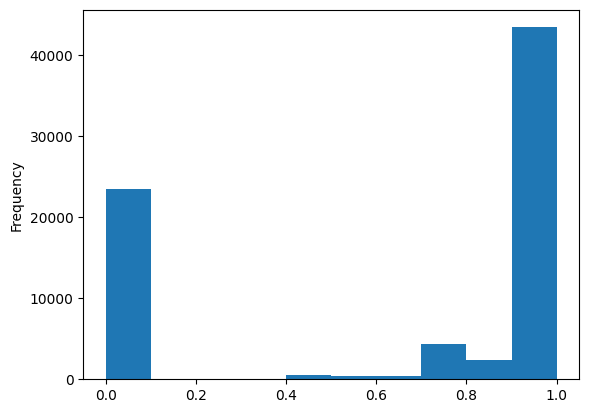

In [1428]:
data_ald_by_service_id.payout_ratio.plot(kind='hist');plt.show()

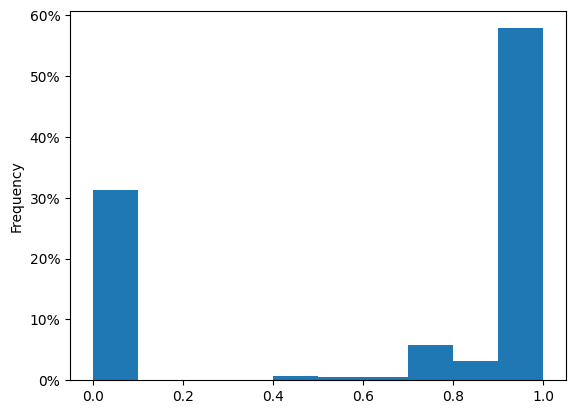

In [1430]:
from matplotlib.ticker import PercentFormatter

data_ald_by_service_id.payout_ratio.plot(kind='hist',weights=np.ones(len(data_ald_by_service_id)) / len(data_ald_by_service_id))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [1442]:
data_ald_by_service_id.Procedure_Code.value_counts()

36416    9959
83036    8659
82044    6163
82570    5522
99214    5130
         ... 
82728       1
99422       1
76700       1
87389       1
99222       1
Name: Procedure_Code, Length: 108, dtype: int64

In [1447]:
9600/75156

0.12773431262973017

In [1443]:
data_ald_by_service_id.shape

(75156, 26)

In [1450]:
data_ald_by_service_id[(data_ald_by_service_id.Procedure_Code=="36416") & (data_ald_by_service_id.Amount== 0)]

,Service_ID,Patient_Number,patient_age,Actual_Dr_Name,Place_of_Service_Abbr,Proc_Category_Abbr,Type_of_Service_Abbr,patient_zip_code,patient_sex,Original_Carrier_Name,...,Service_Units,Service_Fee,Allowed,Deductible,Amount,Amount_per_serv_unit,Allowed_per_serv_unit,Service_Fee_per_serv_unit,allowed_ratio,payout_ratio
0,3135709,617000,65,Mary Girjis PA-C,EPS10Mil,LAB CHEM,LAB,48203,F,Molina Medicare Choice Care,...,1.0,18.0,7.777501,NaN,0.0,0.0,7.777501,18.0,0.432083,0.0
9,3140261,275660,68,Tessa Adams PA-C,EPDLiv,LAB CHEM,LAB,48228,F,Medicare Mr,...,1.0,18.0,5.140000,NaN,0.0,0.0,5.140000,18.0,0.285556,0.0
11,3140288,430080,64,Tessa Adams PA-C,EPDLiv,LAB CHEM,LAB,48221,M,Blue Cross Complete (Medicaid),...,1.0,18.0,7.777501,NaN,0.0,0.0,7.777501,18.0,0.432083,0.0
14,3145167,644330,55,Christopher Gadoua PA-C,EPS10Mil,LAB CHEM,LAB,48045,M,Blue Cross Complete (Medicaid),...,1.0,18.0,7.777501,NaN,0.0,0.0,7.777501,18.0,0.432083,0.0
30,3146075,026527,52,Amber Kalabat FNP-BC,EPS10Mil,LAB CHEM,LAB,48072,F,Bcn,...,1.0,18.0,7.777501,NaN,0.0,0.0,7.777501,18.0,0.432083,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75122,5622462,790650,63,Allen Toubia FNP,EPSHarp,LAB CHEM,LAB,480662804,M,Meridian Health Plan Of MI(MEDICAID),...,1.0,22.0,7.680000,NaN,0.0,0.0,7.680000,22.0,0.349091,0.0
75134,5625500,553110,67,Kimberly Haggerty PA,EPDLiv,LAB CHEM,LAB,48221,F,WellCare Health Plan,...,1.0,22.0,7.777501,NaN,0.0,0.0,7.777501,22.0,0.353523,0.0
75140,5631035,319180,86,Kelly Wright,EP Fer,LAB CHEM,LAB,48322,M,Priority Health Medicare,...,1.0,22.0,7.777501,NaN,0.0,0.0,7.777501,22.0,0.353523,0.0
75147,5632340,362820,63,Frank Zuziak FNP-C,EPDLiv,LAB CHEM,LAB,48238,M,WellCare Health Plan,...,1.0,22.0,7.777501,NaN,0.0,0.0,7.777501,22.0,0.353523,0.0


In [1451]:
cpt_payer_allowed_dict['36416']

{'Administrative Concepts Inc': 8.392857142857142,
 'Aetna': 16.524166666666666,
 'Aetna Dual Complete': 18.0,
 'Aetna Medicare': 3.168275862068966,
 'Aetna Medicare Assure': 2.72,
 'Aetna Voluntary': 17.0825,
 'Aetna(Medicaid) Better Health of Mi': 4.5,
 'Alliance Health and Ins Co': 3.82,
 'Allied Benefit Systems Inc': 2.99,
 'BCBS of Michigan': 2.14,
 'BCBS of Michigan - Ep': 2.14,
 'Bind UnitedHealth Group': 1.98,
 'Champva': 8.57,
 'Cigna': 18.0,
 'Employee Benefit Logistics': 18.0,
 'Hap': 3.486666666666667,
 'Hap Preferred PPO': 3.82,
 'MEDICA': 1.98,
 'Mclaren Health Plan': 11.09235294117647,
 'Mclaren Medicaid Health Plan': 15.0,
 'Medicaid   Michigan  Mdch': 15.0,
 'Medicare  Mr': 5.14,
 'Meridian Health Plan Of MI(MEDICAID)': 7.68,
 'Meridian Healthcare of Mi': 7.68,
 'Meritain Health': 2.6,
 'Molina Marketplace': 10.59,
 'PHCS Limit Benefits Plan': 2.99,
 'Paramount Healthcare': 2.72,
 'Trustmark Health Benefits': 2.79,
 'UMR': 8.108225806451614,
 'United Healthcare': 1.979

In [1441]:
data_ald_by_service_id[data_ald_by_service_id.payout_ratio==0].Procedure_Code.value_counts()[data_ald_by_service_id[data_ald_by_service_id.payout_ratio==0].Procedure_Code.value_counts()>5]

36416    9608
36415    1727
82570    1522
82962    1132
92250    1006
83036    1001
82044     862
80053     654
99214     653
81002     646
G0506     505
G9001     477
G9008     473
84443     439
80061     427
93922     288
99051     233
99490     209
G9002     142
1111F     140
95250     139
95251     136
99489     136
93000     134
99439     108
85025      88
80048      74
G9007      71
94690      64
99204      62
99213      60
82043      54
99487      41
99211      22
84439      11
99203      10
Name: Procedure_Code, dtype: int64